In [1]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.stats as stt
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# UPDATE THE PATH BELOW TO THE CODE FOLDER

In [2]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

# Load stuff

In [3]:
"""Python module for regularized kernel canonical correlation analysis"""

import h5py
import joblib
import numpy as np
from scipy.linalg import eigh

__copyright__ = "Copyright 2016, UC Berkeley, Gallant lab."

__all__ = ["CCA", "CCACrossValidate"]


class _CCABase(object):
    def __init__(
            self,
            numCV=None,
            reg=None,
            regs=None,
            numCC=None,
            numCCs=None,
            kernelcca=True,
            ktype=None,
            verbose=False,
            select=0.2,
            cutoff=1e-15,
            gausigma=1.0,
            degree=2,
    ):
        self.numCV = numCV
        self.reg = reg
        self.regs = regs
        self.numCC = numCC
        self.numCCs = numCCs
        self.kernelcca = kernelcca
        self.ktype = ktype
        self.cutoff = cutoff
        self.select = select
        self.gausigma = gausigma
        self.degree = degree
        if self.kernelcca and self.ktype is None:
            self.ktype = "linear"
        self.verbose = verbose

    def train(self, data):
        if self.verbose:
            print(
                "Training CCA, kernel = %s, regularization = %0.4f, "
                "%d components" % (self.ktype, self.reg, self.numCC)
            )

        comps = kcca(
            data,
            self.reg,
            self.numCC,
            kernelcca=self.kernelcca,
            ktype=self.ktype,
            gausigma=self.gausigma,
            degree=self.degree,
        )
        self.cancorrs, self.ws, self.comps = recon(
            data, comps, kernelcca=self.kernelcca
        )
        if len(data) == 2:
            self.cancorrs = self.cancorrs[np.nonzero(self.cancorrs)]
        return self

    def validate(self, vdata):
        vdata = [np.nan_to_num(_zscore(d)) for d in vdata]
        if not hasattr(self, "ws"):
            raise NameError("Algorithm has not been trained.")
        self.preds, self.corrs = predict(vdata, self.ws, self.cutoff)
        return self.corrs

    def compute_ev(self, vdata):
        nD = len(vdata)
        nC = self.ws[0].shape[1]
        nF = [d.shape[1] for d in vdata]
        self.ev = [np.zeros((nC, f)) for f in nF]
        for cc in range(nC):
            ccs = cc + 1
            if self.verbose:
                print("Computing explained variance for component #%d" % ccs)
            preds, corrs = predict(
                vdata, [w[:, ccs - 1: ccs] for w in self.ws], self.cutoff
            )
            resids = [abs(d[0] - d[1]) for d in zip(vdata, preds)]
            for s in range(nD):
                ev = abs(vdata[s].var(0) - resids[s].var(0)) / vdata[s].var(0)
                ev[np.isnan(ev)] = 0.0
                self.ev[s][cc] = ev
        return self.ev

    def save(self, filename):
        h5 = h5py.File(filename, "a")
        for key, value in self.__dict__.items():
            if value is not None:
                if isinstance(value, list):
                    for di in range(len(value)):
                        grpname = "dataset%d" % di
                        dgrp = h5.require_group(grpname)
                        try:
                            dgrp.create_dataset(key, data=value[di])
                        except RuntimeError:
                            del h5[grpname][key]
                            dgrp.create_dataset(key, data=value[di])
                else:
                    h5.attrs[key] = value
        h5.close()

    def load(self, filename):
        h5 = h5py.File(filename, 'r')
        for key, value in h5.attrs.items():
            setattr(self, key, value)
        for di in range(len(h5.keys())):
            ds = "dataset%d" % di
            for key, value in h5[ds].items():
                if di == 0:
                    setattr(self, key, [])
                self.__getattribute__(key).append(value[()])
        h5.close()


class CCACrossValidate(_CCABase):
    """
    Attributes:
        numCV (int): number of cross-validation folds
        regs (list or numpy.array): regularization param array.
                                   Default: np.logspace(-3, 1, 10)
        numCCs (list or numpy.array): list of numbers of canonical dimensions
                                     to keep. Default is np.range(5, 10).
        kernelcca (bool): kernel or non-kernel CCA. Default is True.
        ktype (string): type of kernel used if kernelcca is True.
                        Value can be 'linear' (default) or 'gaussian'.
        verbose (bool): default is True.
    Returns:
        ws (list): canonical weights
        comps (list): canonical components
        cancorrs (list): correlations of the canonical components
                         on the training dataset
        corrs (list): correlations on the validation dataset
        preds (list): predictions on the validation dataset
        ev (list): explained variance for each canonical dimension
    """

    def __init__(
            self,
            numCV=None,
            regs=None,
            numCCs=None,
            kernelcca=True,
            ktype=None,
            verbose=True,
            select=0.2,
            cutoff=1e-15,
            gausigma=1.0,
            degree=2,
    ):
        numCV = 10 if numCV is None else numCV
        regs = np.array(np.logspace(-3, 1, 10)) if regs is None else regs
        numCCs = np.arange(5, 10) if numCCs is None else numCCs
        super(CCACrossValidate, self).__init__(
            numCV=numCV,
            regs=regs,
            numCCs=numCCs,
            kernelcca=kernelcca,
            ktype=ktype,
            verbose=verbose,
            select=select,
            cutoff=cutoff,
            gausigma=gausigma,
            degree=degree,
        )

    def train(self, data, parallel=True):
        """
        Train CCA with cross-validation for a set of regularization
        coefficients and/or numbers of CCs
        Attributes:
            data (list): training data matrices
                         (number of samples X number of features).
                         Number of samples must match across datasets.
            parallel (bool): use joblib to train cross-validation folds
                             in parallel
        """
        corr_mat = np.zeros((len(self.regs), len(self.numCCs)))
        selection = max(int(self.select * min([d.shape[1] for d in data])), 1)
        for ri, reg in enumerate(self.regs):
            for ci, numCC in enumerate(self.numCCs):
                running_corr_mean_sum = 0.0
                if parallel:
                    fold_corr_means = joblib.Parallel(n_jobs=self.numCV)(
                        joblib.delayed(train_cvfold)(
                            data=data,
                            reg=reg,
                            numCC=numCC,
                            kernelcca=self.kernelcca,
                            ktype=self.ktype,
                            gausigma=self.gausigma,
                            degree=self.degree,
                            cutoff=self.cutoff,
                            selection=selection,
                        )
                        for _ in range(self.numCV)
                    )
                    running_corr_mean_sum += sum(fold_corr_means)
                else:
                    for cvfold in range(self.numCV):
                        fold_corr_mean = train_cvfold(
                            data=data,
                            reg=reg,
                            numCC=numCC,
                            kernelcca=self.kernelcca,
                            ktype=self.ktype,
                            gausigma=self.gausigma,
                            degree=self.degree,
                            cutoff=self.cutoff,
                            selection=selection,
                        )
                        running_corr_mean_sum += fold_corr_mean

                corr_mat[ri, ci] = running_corr_mean_sum / self.numCV
        best_ri, best_ci = np.where(corr_mat == corr_mat.max())
        self.best_reg = self.regs[best_ri[0]]
        self.best_numCC = self.numCCs[best_ci[0]]

        comps = kcca(
            data,
            self.best_reg,
            self.best_numCC,
            kernelcca=self.kernelcca,
            ktype=self.ktype,
            gausigma=self.gausigma,
            degree=self.degree,
        )
        self.cancorrs, self.ws, self.comps = recon(
            data, comps, kernelcca=self.kernelcca
        )
        if len(data) == 2:
            self.cancorrs = self.cancorrs[np.nonzero(self.cancorrs)]
        return self


def train_cvfold(
        data, reg, numCC, kernelcca, ktype, gausigma, degree, cutoff, selection
):
    """
    Train a cross-validation fold of CCA
    """
    nT = data[0].shape[0]
    chunklen = 10 if nT > 50 else 1
    nchunks = int(0.2 * nT / chunklen)
    indchunks = list(zip(*[iter(range(nT))] * chunklen))
    np.random.shuffle(indchunks)
    heldinds = [ind for chunk in indchunks[:nchunks] for ind in chunk]
    notheldinds = list(set(range(nT)) - set(heldinds))
    comps = kcca(
        [d[notheldinds] for d in data],
        reg,
        numCC,
        kernelcca=kernelcca,
        ktype=ktype,
        gausigma=gausigma,
        degree=degree,
    )
    cancorrs, ws, ccomps = recon(
        [d[notheldinds] for d in data], comps, kernelcca=kernelcca
    )
    preds, corrs = predict([d[heldinds] for d in data], ws, cutoff=cutoff)
    fold_corr_mean = []
    for corr in corrs:
        corr_idx = np.argsort(corr)[::-1]
        corr_mean = corr[corr_idx][:selection].mean()
        fold_corr_mean.append(corr_mean)
    return np.mean(fold_corr_mean)


class CCA(_CCABase):
    """Attributes:
        reg (float): regularization parameter. Default is 0.1.
        numCC (int): number of canonical dimensions to keep. Default is 10.
        kernelcca (bool): kernel or non-kernel CCA. Default is True.
        ktype (string): type of kernel used if kernelcca is True.
                        Value can be 'linear' (default) or 'gaussian'.
        verbose (bool): default is True.
    Returns:
        ws (list): canonical weights
        comps (list): canonical components
        cancorrs (list): correlations of the canonical components
                         on the training dataset
        corrs (list): correlations on the validation dataset
        preds (list): predictions on the validation dataset
        ev (list): explained variance for each canonical dimension
    """

    def __init__(
            self, reg=0.0, numCC=10, kernelcca=True, ktype=None, verbose=True, cutoff=1e-15
    ):
        super(CCA, self).__init__(
            reg=reg,
            numCC=numCC,
            kernelcca=kernelcca,
            ktype=ktype,
            verbose=verbose,
            cutoff=cutoff,
        )

    def train(self, data):
        return super(CCA, self).train(data)


def predict(vdata, ws, cutoff=1e-15):
    """Get predictions for each dataset based on the other datasets
    and weights. Find correlations with actual dataset."""
    iws = [np.linalg.pinv(w.T, rcond=cutoff) for w in ws]
    ccomp = _listdot([d.T for d in vdata], ws)
    ccomp = np.array(ccomp)
    preds = []
    corrs = []

    for dnum in range(len(vdata)):
        idx = np.ones((len(vdata),))
        idx[dnum] = False
        proj = ccomp[idx > 0].mean(0)
        pred = np.dot(iws[dnum], proj.T).T
        pred = np.nan_to_num(_zscore(pred))
        preds.append(pred)
        cs = np.nan_to_num(_rowcorr(vdata[dnum].T, pred.T))
        corrs.append(cs)
    return preds, corrs


def kcca(
        data, reg=0.0, numCC=None, kernelcca=True, ktype="linear", gausigma=1.0, degree=2
):
    """Set up and solve the kernel CCA eigenproblem"""
    if kernelcca:
        kernel = [
            _make_kernel(d, ktype=ktype, gausigma=gausigma, degree=degree) for d in data
        ]
    else:
        kernel = [d.T for d in data]

    nDs = len(kernel)
    nFs = [k.shape[0] for k in kernel]
    numCC = min([k.shape[0] for k in kernel]) if numCC is None else numCC

    # Get the auto- and cross-covariance matrices
    crosscovs = [np.dot(ki, kj.T) for ki in kernel for kj in kernel]

    # Allocate left-hand side (LH) and right-hand side (RH):
    n = sum(nFs)
    LH = np.zeros((n, n))
    RH = np.zeros((n, n))

    # Fill the left and right sides of the eigenvalue problem
    for i in range(nDs):
        RH[
        sum(nFs[:i]): sum(nFs[: i + 1]), sum(nFs[:i]): sum(nFs[: i + 1])
        ] = crosscovs[i * (nDs + 1)] + reg * np.eye(nFs[i])

        for j in range(nDs):
            if i != j:
                LH[
                sum(nFs[:j]): sum(nFs[: j + 1]), sum(nFs[:i]): sum(nFs[: i + 1])
                ] = crosscovs[nDs * j + i]

    LH = (LH + LH.T) / 2.0
    RH = (RH + RH.T) / 2.0

    maxCC = LH.shape[0]
    r, Vs = eigh(LH, RH, eigvals=(maxCC - numCC, maxCC - 1))
    r[np.isnan(r)] = 0
    rindex = np.argsort(r)[::-1]
    comp = []
    Vs = Vs[:, rindex]
    for i in range(nDs):
        comp.append(Vs[sum(nFs[:i]): sum(nFs[: i + 1]), :numCC])
    return comp


def recon(data, comp, corronly=False, kernelcca=True):
    # Get canonical variates and CCs
    if kernelcca:
        ws = _listdot(data, comp)
    else:
        ws = comp
    ccomp = _listdot([d.T for d in data], ws)
    corrs = _listcorr(ccomp)
    if corronly:
        return corrs
    else:
        return corrs, ws, ccomp


def _zscore(d):
    return (d - d.mean(0)) / d.std(0)


def _demean(d):
    return d - d.mean(0)


def _listdot(d1, d2):
    return [np.dot(x[0].T, x[1]) for x in zip(d1, d2)]


def _listcorr(a):
    """Returns pairwise row correlations for all items in array as a list of matrices"""
    corrs = np.zeros((a[0].shape[1], len(a), len(a)))
    for i in range(len(a)):
        for j in range(len(a)):
            if j > i:
                corrs[:, i, j] = [
                    np.nan_to_num(np.corrcoef(ai, aj)[0, 1])
                    for (ai, aj) in zip(a[i].T, a[j].T)
                ]
    return corrs


def _rowcorr(a, b):
    """Correlations between corresponding matrix rows"""
    cs = np.zeros((a.shape[0]))
    for idx in range(a.shape[0]):
        cs[idx] = np.corrcoef(a[idx], b[idx])[0, 1]
    return cs


def _make_kernel(d, normalize=True, ktype="linear", gausigma=1.0, degree=2):
    """Makes a kernel for data d
    If ktype is 'linear', the kernel is a linear inner product
    If ktype is 'gaussian', the kernel is a Gaussian kernel, sigma = gausigma
    If ktype is 'poly', the kernel is a polynomial kernel with degree=degree
    """
    d = np.nan_to_num(d)
    cd = _demean(d)
    if ktype == "linear":
        kernel = np.dot(cd, cd.T)
    elif ktype == "gaussian":
        from scipy.spatial.distance import pdist, squareform

        pairwise_dists = squareform(pdist(d, "euclidean"))
        kernel = np.exp((-(pairwise_dists ** 2)) / (2 * gausigma ** 2))
    elif ktype == "poly":
        kernel = np.dot(cd, cd.T) ** degree
    kernel = (kernel + kernel.T) / 2.0
    if normalize:
        kernel = kernel / np.linalg.eigvalsh(kernel).max()
    return kernel


In [52]:
#These are the times (in units of the behaviour system bin running @1000Hz) at which spikes occurred

selected_session = 0

all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


#This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

#This is basically a big table (you can open it in excel) which contains
#relevant information about each time the animal poked one of the ports
task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

#
response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
#alternatively to change the time window


#not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
single_units = np.load(os.path.join(root_dir,'single_units.npy'))

In [53]:
#np.unique(task_event_df['graph_type'])

In [54]:
seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))

In [55]:
graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
graph_type1 = task_event_df.loc[task_event_df['task_nr']==1]['graph_type'].values[0]
print(graph_type0,graph_type1)

loop loop


In [56]:
def load_data(selected_session):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    firing_rate_maps = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, task_event_df

In [57]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [60]:
firing_rate_maps, task_event_df = load_data(0)
spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
mds_frm = firing_rate_maps #- spatial_map[:,:,None,None]
#valid_ix = np.where(~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3))))[0]
frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

In [61]:
D1 = frm[:,:9]
D2 = frm[:,9:18]#[:,np.random.permutation(range(9))]
D3 = frm[:,18:27]
D4 = frm[:,27:]

D1 = (D1 - np.mean(D1,axis=0))
D2 = (D2 - np.mean(D2,axis=0))
D3 = (D3 - np.mean(D3,axis=0))
D4 = (D4 - np.mean(D4,axis=0))

In [96]:
U1,S1,V1 = np.linalg.svd(D1)
U2,S2,V2 = np.linalg.svd(D3)

In [97]:
U1.shape

(135, 135)

In [98]:
hat_dims = 6
Uhat1 = U1[:,:hat_dims]
Uhat2 = U2[:,:hat_dims]

In [99]:
L1 = np.dot(Uhat1.T,D1)
L2 = np.dot(Uhat2.T,D2)

In [100]:
Q1,R1 = np.linalg.qr(L1.T)
Q2,R2 = np.linalg.qr(L2.T)

In [101]:
Ub,Sb,Vb = np.linalg.svd(Q1.T@Q2)

In [102]:
M1 = np.linalg.pinv(R1)@Ub
M2 = np.linalg.pinv(R2)@Vb.T

In [103]:
Uf,Sf,Vf = np.linalg.svd(np.dot(M1.T,L1).T@np.dot(M2.T,L2))

In [104]:
np.rad2deg(np.nan_to_num(np.arccos(Sf),0))

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


array([0.00000000e+00, 0.00000000e+00, 1.20741827e-06, 1.90909591e-06,
       1.90909591e-06, 2.56132094e-06, 9.00000000e+01, 9.00000000e+01,
       9.00000000e+01])

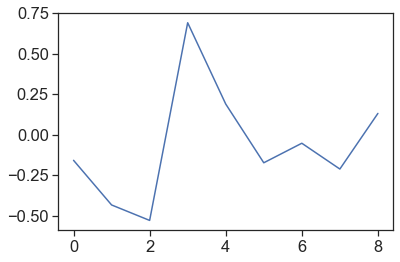

In [118]:
plt.plot(np.dot(M1.T,L1)[0])

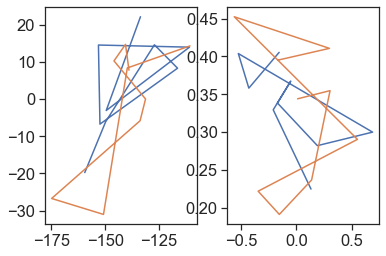

In [119]:
ix = 0

plt.subplot(1,2,1)
plt.plot(L1[0],L1[1])
plt.plot(L2[0],L2[1])


plt.subplot(1,2,2)
plt.plot(np.dot(M1.T,L1)[ix],np.dot(M1.T,L1)[ix+1])
plt.plot(np.dot(M2.T,L2)[ix],np.dot(M2.T,L2)[ix+1])


In [120]:
L1 = np.dot(Uhat1.T,D4)
L2 = np.dot(Uhat2.T,D2)

In [121]:
Uf,Sf,Vf = np.linalg.svd(np.dot(M1.T,L1).T@np.dot(M2.T,L2))

In [122]:
np.rad2deg(np.nan_to_num(np.arccos(Sf),0))

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


array([ 0.        ,  0.        , 35.16159579, 49.37061347, 54.4898626 ,
       65.64195475, 90.        , 90.        , 90.        ])

In [112]:
np.rad2deg(np.nan_to_num(np.arccos(Sf),0))

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


array([ 0.        ,  0.        , 35.16159579, 49.37061347, 54.4898626 ,
       65.64195475, 90.        , 90.        , 90.        ])